# Data Preparation for Rookie of the Year

In this notebook we will prepare the data for the Rookie of the Year award prediction.

#### Load Dependencies

In [50]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Get Rookies From The Player Dataset

This section identifies rookie players for each season:

- **Select Key Columns:** Extract player ID, year, team ID, and stint from the player-team dataset.  
- **Add Season 11 Data:** Include additional data from Season 11 to ensure completeness.
- **Define Rookie Function:** Create a function to filter players in their debut season, excluding year 1 and limiting to primary stints.  
- **Apply Function:** Generate the rookies dataframe for analysis.

In [51]:
players_info_with_normal_data_df = sd.players_teams_df[['playerID', 'year', 'tmID', 'stint']]

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")

players_info_with_normal_data_df = pd.concat([players_info_with_normal_data_df, players_teams_year11_df[['playerID', 'year', 'tmID', 'stint']]], ignore_index=True)

def get_rookies(playerTeams_df):
    rookies = playerTeams_df[playerTeams_df['year'] == playerTeams_df.groupby('playerID')['year'].transform('min')]
    rookies = rookies[rookies['year'] != 1]
    rookies = rookies[rookies['stint'].isin([0, 1])]
    return rookies

rookies_df = get_rookies(players_info_with_normal_data_df).copy()

#### Get Team Previous Rank

This section adds the previous season's team ranking as a feature:

- **Calculate Previous Year:** Shift the year back by 1 for each rookie.  
- **Merge Team Ranks:** Combine with the teams dataset to get the rank from the prior year.  
- **Encode Team ID:** Use label encoding for the team ID to prepare for modeling.  
- **Handle Missing Ranks:** Fill any missing ranks with 0 and rename the column.

In [ ]:
rookies_df['prev_year'] = rookies_df['year'] - 1
prev_year_rank = sd.teams_df[['tmID', 'year', 'rank']]

rookies_df = rookies_df.merge(
    prev_year_rank,
    left_on=['tmID', 'prev_year'],
    right_on=['tmID', 'year'],
    how='left',
    suffixes=('', '_prev')
)

le_tmID = LabelEncoder()
rookies_df['tmID'] = le_tmID.fit_transform(rookies_df['tmID'])

rookies_df = rookies_df.rename(columns={'rank': 'team_prev_rank'})
rookies_df['team_prev_rank'] = rookies_df['team_prev_rank'].astype('Int64')
rookies_df['team_prev_rank'] = rookies_df['team_prev_rank'].fillna(0).astype(int)

#### Calculate College Players Sent To The WNBA Before

This section computes how many players from the same college were drafted before the current rookie:

- **Merge College Data:** Join with the players dataset to get college information.  
- **Sort by College and Year:** Organize data to track chronological order per college.  
- **Cumulative Count:** Calculate the running count of players sent to WNBA from each college up to the previous year.  
- **Fill Missing Values:** Ensure the count is an integer and handle any NaNs.

In [53]:
college = sd.players_df[['bioID', 'college']]

rookies_df = rookies_df.merge(
    college,
    left_on='playerID',
    right_on='bioID',
    how='left'
)

rookies_df = rookies_df.drop(columns=['bioID'])

rookies_df = rookies_df.sort_values(['college', 'year'])

rookies_df['college_count_before'] = (
    rookies_df.groupby('college').cumcount()
)

rookies_df['college_count_before'] = rookies_df['college_count_before'].fillna(0).astype(int)

le_college = LabelEncoder()
rookies_df['college'] = le_college.fit_transform(rookies_df['college'])
rookies_df['college'] = rookies_df['college'].fillna(-1)

#### Merge Rookie of the Year Award Information

This step incorporates the target variable for modeling rookie performance:

- **Filter Awards:** Identify Rookie of the Year awards from the awards dataset.  
- **Add Indicator:** Create a column marking winners (1) or non-winners (0).  
- **Merge with Rookies:** Combine award data with the rookies dataframe.  
- **Prepare for Modeling:** Ensure the dataset includes features and the target variable.

In [54]:
rookie_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'rookie of the year'].copy()
rookie_aw['rookie'] = 1

rookies_df = rookies_df.merge(rookie_aw[['playerID', 'year', 'rookie']], on=['playerID', 'year'], how='left')
rookies_df['rookie'] = rookies_df['rookie'].fillna(0).astype(int)

#### Remove Columns and Save CSV

This step finalizes the rookies dataset:

- **Drop Unnecessary Columns:** Remove intermediate or irrelevant columns like previous year, stint, and college.  
- **Save to CSV:** Export the cleaned dataset to a CSV file for predictive modeling.  
- **Ready for Analysis:** The dataset now contains key features for rookie award prediction.

In [55]:
rookies_df = rookies_df.drop(columns=['prev_year', 'year_prev', 'stint'])
rookies_df.to_csv("../predict_datasets/rookies.csv", index=False)

#### Idea For the Dataset Preparation

Since this is the Rookie dataset, we lack information on player performance prior to entering the WNBA. Therefore, we included several proxy variables to help assess rookie potential.

First, we incorporated the number of players drafted into the WNBA from each prospect’s college program. A higher number indicates a program known for producing high-level talent, suggesting the rookie may have been developed in a competitive environment.

Second, we accounted for the drafting team’s ranking in the previous season. Historically, the worst-ranked teams receive the highest draft picks, giving them priority access to the most promising rookies. Therefore, a lower team rank correlates with a higher likelihood of selecting top-tier talent.

Finally, we thought that some teams can be better at developing rookies, which may influence a player’s success in their first season. This factor was also considered when evaluating rookie prospects.

#### Data Correlation Analysis

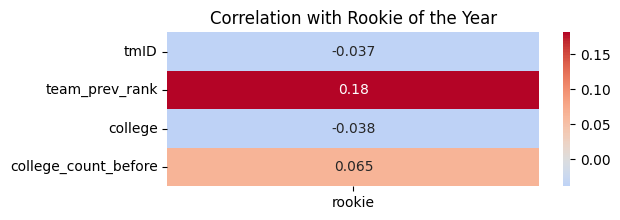

In [56]:
score_cols = ['tmID', 'team_prev_rank', 'college', 'college_count_before', 'rookie']
df_scores = rookies_df[score_cols]

corr_matrix = df_scores.corr()[['rookie']]

corr_matrix = corr_matrix.drop('rookie')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Rookie of the Year")
plt.show()